In [46]:
import numpy as np 
import matplotlib.pyplot as plt 
import json

from datasets import load_dataset
from collections import Counter
from is_eq import * 
import tqdm

In [47]:
dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])


In [73]:
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

In [74]:

def extract_latex(text):
    start = text.find("#### ") + len("#### ")
    return text[start:].replace(",", "")

def maj_correct(outputs , answer):
    answer = extract_latex(answer)

    output_answers = [extract_latex(output) for output in outputs]
    
    maj_answer = most_frequent(output_answers)
    
    eqiv = is_equiv(answer, maj_answer, verbose=False)

    return eqiv

In [75]:
def get_n_maj_acc(arr, n, num_samples=1):
    o = []
    for i in range(num_samples):
        idxs = np.random.choice(arr.shape[-1], n, replace=False)
        maj_correct_all = [maj_correct(arr[j, idxs], test_answers[j]) for j in range(arr.shape[0])]
        # print(maj_correct_all)
        # print(len(maj_correct_all))
        # 1/0
        o.append(np.mean(maj_correct_all))
    return np.mean(o)

In [8]:
X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-348/test_answers50_seed2.npy")

majN_5 = []
for n in tqdm.tqdm(range(1, 51)):
    majN_5.append(get_n_maj_acc(X, n))


100%|██████████| 50/50 [00:34<00:00,  1.43it/s]


In [9]:
X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-348/test_answers50_seed2.npy")

majN_7 = []
for n in tqdm.tqdm(range(1, 51)):
    majN_7.append(get_n_maj_acc(X, n))


100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


In [18]:
X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-58/test_answers50_seed2.npy")

majN_7_58 = []
for n in tqdm.tqdm(range(1, 51)):
    majN_7_58.append(get_n_maj_acc(X, n))


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]


In [11]:
X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-58/test_answers50_seed2.npy")

majN_5_58 = []
for n in tqdm.tqdm(range(1, 51)):
    majN_5_58.append(get_n_maj_acc(X, n))

100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


In [14]:
X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-116/test_answers50_seed2.npy")

majN_5_116 = []
for n in tqdm.tqdm(range(1, 51)):
    majN_5_116.append(get_n_maj_acc(X, n))

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


In [16]:
X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-175/test_answers50_seed2.npy")

majN_5_175 = []
for n in tqdm.tqdm(range(1, 51)):
    majN_5_175.append(get_n_maj_acc(X, n))

100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


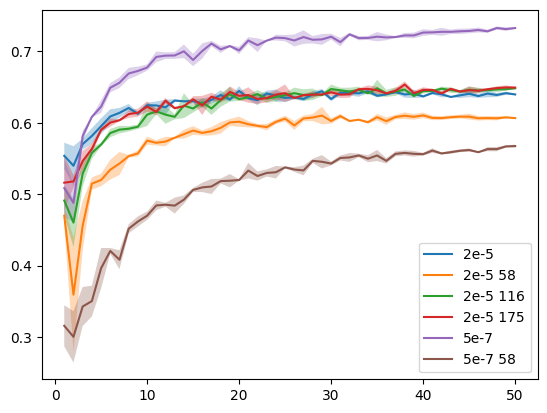

In [19]:
plt.plot(range(1, 51), np.mean(majN_5, axis=1), label="2e-5")
plt.fill_between(range(1, 51), np.mean(majN_5, axis=1) - np.std(majN_5, axis=1), np.mean(majN_5, axis=1) + np.std(majN_5, axis=1), alpha=0.3)


plt.plot(range(1, 51), np.mean(majN_5_58, axis=1), label="2e-5 58")
plt.fill_between(range(1, 51), np.mean(majN_5_58, axis=1) - np.std(majN_5_58, axis=1), np.mean(majN_5_58, axis=1) + np.std(majN_5_58, axis=1), alpha=0.3)

plt.plot(range(1, 51), np.mean(majN_5_116, axis=1), label="2e-5 116")
plt.fill_between(range(1, 51), np.mean(majN_5_116, axis=1) - np.std(majN_5_116, axis=1), np.mean(majN_5_116, axis=1) + np.std(majN_5_116, axis=1), alpha=0.3)

plt.plot(range(1, 51), np.mean(majN_5_175, axis=1), label="2e-5 175")
plt.fill_between(range(1, 51), np.mean(majN_5_175, axis=1) - np.std(majN_5_175, axis=1), np.mean(majN_5_175, axis=1) + np.std(majN_5_175, axis=1), alpha=0.3)

plt.plot(range(1, 51), np.mean(majN_7, axis=1), label="5e-7")
plt.fill_between(range(1, 51), np.mean(majN_7, axis=1) - np.std(majN_7, axis=1), np.mean(majN_7, axis=1) + np.std(majN_7, axis=1), alpha=0.3)


plt.plot(range(1, 51), np.mean(majN_7_58, axis=1), label="5e-7 58")
plt.fill_between(range(1, 51), np.mean(majN_7_58, axis=1) - np.std(majN_7_58, axis=1), np.mean(majN_7_58, axis=1) + np.std(majN_7_58, axis=1), alpha=0.3)


plt.legend()

In [ ]:
# plot distributions over final answers for different training runs
# look at diversity of final answers

In [27]:
X5 = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-348/test_answers50_seed2.npy")
X7 = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-348/test_answers50_seed2.npy")


In [65]:
i =20


print(extract_latex(test_answers[i]))

answers = [extract_latex(sample) for sample in X5[i]]
for answer in set(answers):
    print(answer, answers.count(answer))

15
3.6 1
24 3
14.666 5
7 1
14.67 1
7.34 1
18 1
65 1
345 1
15.67 1
21.67 1
16 2
11 1
1 1
23 9
13 2
15.666 2
14.66 1
30/5 1
15 3
6 1
22 1
14 2
20 1
19 2
0 1
17.666 1
7.33 1
12 1


In [63]:
answers = [extract_latex(sample) for sample in X7[i]]

for answer in set(answers):
    print(answer, answers.count(answer))

14.667 1
759 1
8.33 1
14.67 2
17.33 1
12.34 1
9 1
15.6667 2
14.7 1
12.6666666666667 1
15.6666666666667 1
31.667 2
15.67 5
15.6 1
19.28 1
0.66 1
16.667 1
30.67 1
-1 1
1 1
8.333 1
119 1
21 3
31.67 1
8 1
8.3 1
15 3
6 1
9.4 1
14.6667 4
11.666666666667 1
28 1
10.3333333333333 1
12 1
30.6666666666667 1
22.6666666667 1


In [67]:

num_unique_answers5 = []
num_unique_answers7 = []


for i in range(1000):
    num_unique_answers5.append(len(set([extract_latex(sample) for sample in X5[i]])))
    num_unique_answers7.append(len(set([extract_latex(sample) for sample in X7[i]])))


In [72]:
# np.mean(num_unique_answers5), np.mean(num_unique_answers7)
np.std(num_unique_answers5), np.std(num_unique_answers7)

(7.939987342559181, 9.069971058388225)

In [ ]:
# look at where one get its right and the other gets it wrong
# differences in samples?